In [1]:
from load import *
from torch import Tensor, nn
import torch
from modules import *

## Second part of the graph
net = torch.load("./Datas/Week 7/VAE model 1/model.pt")

In [ ]:
Q = 1.60217663e-19
def load():
    ep = load_elec_potential().reshape(-1, 2193)
    sc = (load_space_charge() * (-Q)).reshape(-1, 2193)
    epsc = torch.cat([ep, sc], axis = -1)
    return epsc

print(load().shape)

In [20]:
device = get_device()
net = net.to(device).double()
x = load().to(device)
y = net(x)
print(y.shape)

torch.Size([101, 4386])


In [21]:
class Progress:
    def __init__(self, pad = 200):
        self.pad = pad
    
    def rint(self, content: str):
        print(content.ljust(self.pad), end = '\r')
        self.pad = max(self.pad, len(content) + 1)

In [ ]:
def train(net, epochs):
    device = get_device()
    net = VAENet1(net).to(device).double()
    opt = torch.optim.Adam(net.parameters(), lr = 0.005)
    vg = load_vgs().to(device).double()
    y = load_elec_potential().to(device).double()
    history = []
    p = Progress()
    
    for i in range(epochs):
        def closure():
            if torch.is_grad_enabled():
                opt.zero_grad()
            x = vg
            ypred = net(x)
            loss = torch.sqrt(torch.mean((y - ypred) ** 2))
            if loss.requires_grad:
                loss.backward()

            nonlocal history
            history.append(loss.item())

            nonlocal p
            p.rint(f"Epoch {i}: RMSE = {loss.item()}")
            return loss
        opt.step(closure)

    return net, history

net, history = train(net, 10000)

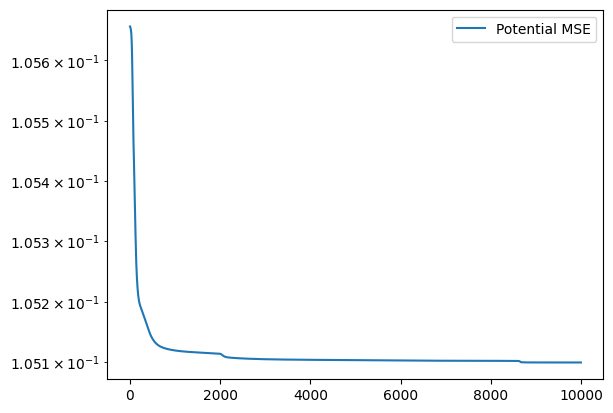

In [23]:
from anim import make_anim
from load import *
import matplotlib.pyplot as plt
from torchsummary import summary
import subprocess

ROOT = "./Datas/Week 7"

def save_stuff(net, history, training_model_no: int, commit: bool = True, name: str = ""):
    # Animation
    device = get_device()
    with torch.no_grad():
        x = load_vgs().to(device).double()
        ypred = net(x).cpu().numpy()
    root = f"{ROOT}/VAE model {training_model_no}"
    ep = load_elec_potential().cpu().numpy()
    make_anim(ypred, ep, f"{root}/{name} potential.gif", "Potential")

    # Graph 
    plt.figure()
    plt.plot(history)
    plt.yscale('log')
    plt.legend(["MSE loss"])
    plt.savefig(f"{root}/{name} model history.png")

    # Model
    torch.save(net, f"{root}/{name} model.pt")

    # Structure
    commit_token = f"VAE {name} model {training_model_no}"
    with open(f"{root}/{name} logs.txt", 'w', encoding='utf-8') as f:
        f.write("Model structure:\n\n")
        f.write(f"{summary(net, verbose=0)}")
        if commit:
            f.write("\n\n")
            f.write(f"Save at the commit \"{commit_token}\"")
    
    # Make a git commit to save the code
    if commit:
        subprocess.call(["git", "add", "."])
        subprocess.call(["git", "commit", "-m", commit_token])
        subprocess.call(["git", "push", "origin", "master"])

save_stuff(net, history, 1, commit=False, name = "ap1")

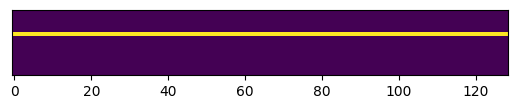

In [6]:
import matplotlib.pyplot as plt
import numpy as np
materials = np.load("./mesh_data_materials.npy")

# Eps = 7.8 at interface
plt.figure()
plt.imshow(materials.T[::-1, :])
plt.yticks([])
plt.show()

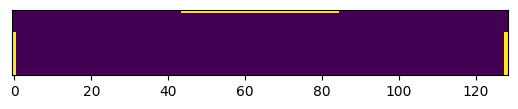

In [7]:
materials = np.load("./mesh_data_contacts.npy")

plt.figure()
plt.imshow(materials.T[::-1, :])
plt.yticks([])
plt.show()